In [1]:
%matplotlib widget
import torch
import os
import copy
if torch.cuda.is_available():
    os.environ['TORCH_CUDA_ARCH_LIST'] = f'{torch.cuda.get_device_properties(0).major}.{torch.cuda.get_device_properties(0).minor}'

import warnings
from tqdm import TqdmExperimentalWarning
warnings.filterwarnings("ignore", category=TqdmExperimentalWarning)
from tqdm.autonotebook import tqdm

import matplotlib.pyplot as plt

from sphMath.operations import sph_operation, mod
from sphMath.sampling import buildDomainDescription, sampleRegularParticles
from sphMath.modules.eos import idealGasEOS
from sphMath.modules.timestep import computeTimestep
from sphMath.schema import getSimulationScheme
from sphMath.reference.sod import buildSod_reference, sodInitialState, generateSod1D
from sphMath.modules.adaptiveSmoothingASPH import n_h_to_nH
from sphMath.reference.sod import plotSod
# from sphMath.reference.linear import buildLinearWaveSimulation, runLinearWaveTest
from sphMath.enums import *
from sphMath.reference.sod import plotSod

In [2]:
from sphMath.kernels import getKernelEnum

In [3]:
# f'{dt.item():.2e}'

In [4]:
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr, filterNeighborhoodByKind
from sphMath.neighborhood import SupportScheme, evaluateNeighborhood
from sphMath.modules.density import computeDensity

In [5]:
import time
import pandas as pd

In [6]:
timingDataset = pd.DataFrame(columns=['timestep', 'time', 'cpuTime', 'gpuTime', 'numParticles', 'precision'])

In [13]:
resolutions = [2**i for i in range(6, 20)]
devices = [torch.device('cuda:0'), torch.device('cpu')]
precisions = [torch.float32, torch.float64]

In [15]:
for nx in resolutions:
    for device in devices:
        for dtype in precisions:
            print(f'Running simulation for resolution {nx} on device {device} with precision {dtype}')
            # device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
            # device = torch.device('cpu')
            # dtype = torch.float32

            # nx = 32
            dim = 1
            kernel = KernelType.B7
            targetNeighbors = n_h_to_nH(4, 1)
            CFL = 0.3

            gamma = 5/3
            initialStateLeft = sodInitialState(1, 1, 0)
            initialStateRight = sodInitialState(0.1795, 0.25, 0)
            ratio = 1
            smoothIC = False
            timeLimit = 0.15

            scheme = SimulationScheme.CompSPH
            integrationScheme = IntegrationSchemeType.rungeKutta2
            viscositySwitch = ViscositySwitch.NoneSwitch
            supportScheme = AdaptiveSupportScheme.NoScheme

            domain = buildDomainDescription(l = 2, dim = 1, periodic = True, device = device, dtype = dtype)

            simulator, SimulationSystem, solverConfig, integrator = getSimulationScheme(
                scheme, kernel, integrationScheme, 
                gamma, targetNeighbors, domain, 
                viscositySwitch=viscositySwitch, supportScheme = supportScheme)
            
            solverConfig['support']['adaptiveHThreshold'] = 0.001
            solverConfig['diffusionSwitch']['alpha_min'] = 0.02
            solverConfig['diffusionSwitch']['correctGradient'] = False
            solverConfig['diffusionSwitch']['beta_xi'] = 2
            solverConfig['diffusionSwitch']['alpha_max'] = 2
            solverConfig['diffusionSwitch']['beta_c'] = 7
            solverConfig['diffusionSwitch']['beta_d'] = 0.05

            particleSystem = generateSod1D(nx, ratio, initialStateLeft, initialStateRight, gamma, solverConfig['kernel'], targetNeighbors, dtype, device, smoothIC, SimulationSystem)

            dt = computeTimestep(scheme, 1e-3, particleSystem.systemState, solverConfig, None)
            timesteps = int(timeLimit / dt)
            timesteps = 250

            simulationState = copy.deepcopy(particleSystem)
            simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
            states = []
            priorStep = None

            neighborhood, neighbors = evaluateNeighborhood(simulationState.systemState, solverConfig['domain'], kernel, verletScale = 1.4, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeDkDh = True, computeHessian = False, useCheckpoint=False)
            simulationState.neighborhoodInfo = neighborhood
            simulationState.systemState.densities = computeDensity(simulationState.systemState, kernel, neighbors.get('noghost'), SupportScheme.Gather, solverConfig)
            start = torch.cuda.Event(enable_timing=True)
            end = torch.cuda.Event(enable_timing=True)

            timings_cuda = []
            timings_cpu = []
            simulationTimes = []
            totalStart = time.time()

            for i in (tq:=tqdm(range(timesteps), leave=False)):
                startTimeCPU = time.time()
                torch.cuda.synchronize()
                start.record()
                simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
                end.record()
                torch.cuda.synchronize()
                endTimeCPU = time.time()
                simulationState.priorStep = [updates[-1], currentState[-1]]
                
                # states.append(copy.deepcopy(simulationState))

                kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
                thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
                totalEnergy = kineticEnergy + thermalEnergy

                tq.set_postfix({
                    'Kinetic Energy': kineticEnergy.item(),
                    'Thermal Energy': thermalEnergy.item(),
                    'Total Energy': totalEnergy.item(),
                    'Time': simulationState.t.item(),
                    'cpuTime': endTimeCPU - startTimeCPU,
                    'gpuTime': start.elapsed_time(end) / 1000,
                    'dt': f'{dt.item():.2e}',
                    'timestep': i,
                    'particles': simulationState.systemState.positions.shape[0],
                })
                timings_cuda.append(start.elapsed_time(end) / 1000)
                timings_cpu.append(endTimeCPU - startTimeCPU)
                simulationTimes.append(simulationState.t.item())
                currentTime = time.time() - totalStart
                if currentTime > 30 and i > 16:
                    print(f'Simulation took {currentTime:.2f} seconds, stopping early.')
                    timesteps = i + 1
                    break


            newData = pd.DataFrame({
                'timestep': range(timesteps),
                'time': simulationTimes,
                'dt': dt.item(),
                'cpuTime': timings_cpu,
                'gpuTime': timings_cuda,
                'totalTime': [t + c for t, c in zip(timings_cuda, timings_cpu)],
                'numParticles': simulationState.systemState.positions.shape[0],
                'precision': dtype,
                'device': device.type,
                'kernel': kernel.name,
                'scheme': scheme.name,
                'viscositySwitch': viscositySwitch.name,
                'supportScheme': supportScheme.name,
                'integrationScheme': integrationScheme.name,
                'n_h': targetNeighbors,
                'CFL': CFL
            })
            timingDataset = pd.concat([timingDataset, newData], ignore_index=True)
            # break
        # break
    # break


Running simulation for resolution 64 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 64 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 64 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 64 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 128 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 128 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 128 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 128 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 256 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 256 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 256 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 256 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 512 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 512 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 512 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 512 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 1024 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 1024 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 1024 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 1024 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 2048 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 2048 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 2048 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 2048 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 4096 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 4096 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 4096 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 4096 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 8192 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 8192 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 8192 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 8192 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 16384 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 16384 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 16384 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 16384 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 32768 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 32768 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 32768 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.13 seconds, stopping early.
Running simulation for resolution 32768 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.13 seconds, stopping early.
Running simulation for resolution 65536 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 65536 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 65536 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.28 seconds, stopping early.
Running simulation for resolution 65536 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.01 seconds, stopping early.
Running simulation for resolution 131072 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 131072 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.11 seconds, stopping early.
Running simulation for resolution 131072 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.60 seconds, stopping early.
Running simulation for resolution 131072 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.42 seconds, stopping early.
Running simulation for resolution 262144 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Running simulation for resolution 262144 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.17 seconds, stopping early.
Running simulation for resolution 262144 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.32 seconds, stopping early.
Running simulation for resolution 262144 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 43.44 seconds, stopping early.
Running simulation for resolution 524288 on device cuda:0 with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.00 seconds, stopping early.
Running simulation for resolution 524288 on device cuda:0 with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 30.41 seconds, stopping early.
Running simulation for resolution 524288 on device cpu with precision torch.float32


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 63.51 seconds, stopping early.
Running simulation for resolution 524288 on device cpu with precision torch.float64


  0%|          | 0/250 [00:00<?, ?it/s]

Simulation took 170.90 seconds, stopping early.


In [11]:
time.time()

1751961305.5187325

In [12]:
newData

,timestep,time,dt,cpuTime,gpuTime,totalTime,numParticles,precision,device,kernel,scheme,viscositySwitch,supportScheme,integrationScheme,n_h,CFL
0,0,2.750132e-07,2.750132e-07,0.146734,0.146518,0.293252,1048576,torch.float32,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
1,1,5.500264e-07,2.750132e-07,0.146998,0.146933,0.293931,1048576,torch.float32,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
2,2,8.250395e-07,2.750132e-07,0.152803,0.152742,0.305544,1048576,torch.float32,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
3,3,1.100053e-06,2.750132e-07,0.149037,0.148975,0.298013,1048576,torch.float32,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
4,4,1.375066e-06,2.750132e-07,0.151840,0.151780,0.303620,1048576,torch.float32,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,245,6.765329e-05,2.750132e-07,0.147886,0.147828,0.295714,1048576,torch.float32,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
246,246,6.792831e-05,2.750132e-07,0.161086,0.161028,0.322113,1048576,torch.float32,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
247,247,6.820333e-05,2.750132e-07,0.155370,0.155311,0.310681,1048576,torch.float32,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
248,248,6.847834e-05,2.750132e-07,0.147836,0.147677,0.295513,1048576,torch.float32,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3


In [16]:
plotSod(states[-1], solverConfig, states[0].domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

IndexError: list index out of range

In [17]:
display(timingDataset)

,timestep,time,cpuTime,gpuTime,numParticles,precision,dt,totalTime,device,kernel,scheme,viscositySwitch,supportScheme,integrationScheme,n_h,CFL
0,0,0.002253,0.048809,0.048645,128,torch.float32,2.252909e-03,0.097454,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
1,1,0.004506,0.020802,0.020715,128,torch.float32,2.252909e-03,0.041518,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
2,2,0.006759,0.021421,0.021353,128,torch.float32,2.252909e-03,0.042774,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
3,3,0.009012,0.019944,0.019877,128,torch.float32,2.252909e-03,0.039821,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
4,4,0.011265,0.020249,0.020155,128,torch.float32,2.252909e-03,0.040404,cuda,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11601,13,0.000004,9.985378,9.985241,1048576,torch.float64,2.750132e-07,19.970619,cpu,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
11602,14,0.000004,10.214381,10.214178,1048576,torch.float64,2.750132e-07,20.428558,cpu,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
11603,15,0.000004,9.151982,9.151864,1048576,torch.float64,2.750132e-07,18.303847,cpu,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3
11604,16,0.000005,9.624010,9.623954,1048576,torch.float64,2.750132e-07,19.247964,cpu,B7,CompSPH,NoneSwitch,NoScheme,rungeKutta2,8.0,0.3


In [18]:
plotData = copy.deepcopy(timingDataset)

In [19]:
plotData['gpuTime']

0         0.048645
1         0.020715
2         0.021353
3         0.019877
4         0.020155
           ...    
11601     9.985241
11602    10.214178
11603     9.151864
11604     9.623954
11605     9.899473
Name: gpuTime, Length: 11606, dtype: float64

In [20]:
import seaborn as sns

In [21]:
plotData['device + precision'] = plotData['device'] + ' ' + plotData['precision'].astype(str)

In [35]:
plotData['Device'] = plotData['device'].apply(lambda x: 'CPU' if x == 'cpu' else 'GPU')
plotData['Precision'] = plotData['precision'].apply(lambda x: 'Single' if x == torch.float32 else 'Double')

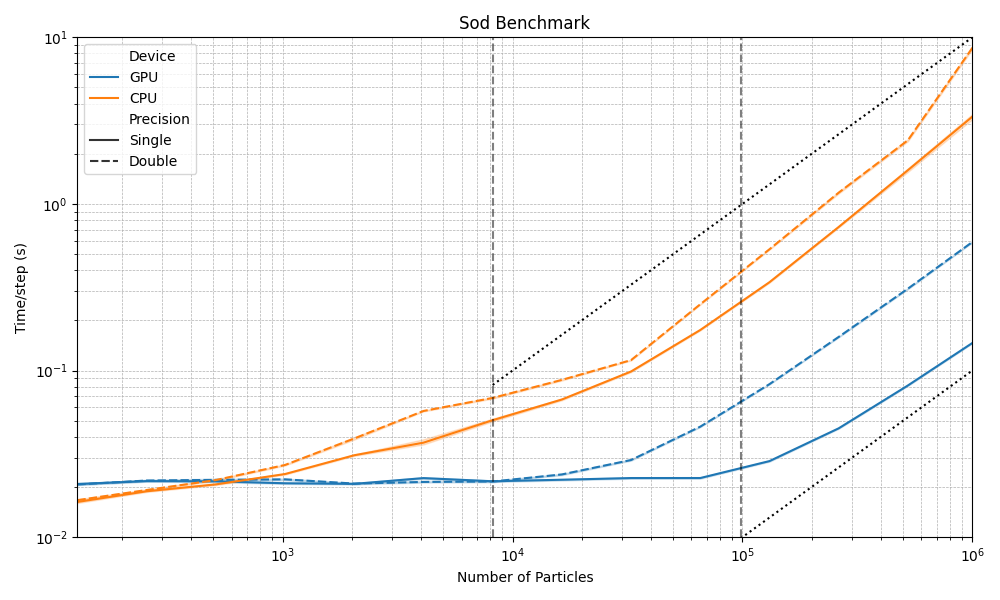

: 

In [ ]:
fig, axis  = plt.subplots(1,1 ,figsize=(10, 6), squeeze=False)

sns.lineplot(data=plotData, x='numParticles', y='gpuTime', hue='Device', style = 'Precision', ax=axis[0,0], estimator='mean')

axis[0,0].set_yscale('log')
axis[0,0].set_xscale('log')

axis[0,0].set_xlabel('Number of Particles')
axis[0,0].set_ylabel('Time/step (s)')

axis[0,0].set_title('Sod Benchmark')
axis[0,0].grid(True, which='both', linestyle='--', linewidth=0.5)

axis[0,0].plot([0.98304 * 10**5, 10**6], [0.98304*0.01, 0.1], ls = ':', label = 'O(N)', color='black')
axis[0,0].plot([0.8192 * 10**4, 10**6], [0.8192 * 0.1, 0.01 * 10**3], ls = ':', label = 'O(N)', color='black')
axis[0,0].set_xlim([128, 10**6])
axis[0,0].set_ylim([1e-2, 1e1])

fig.tight_layout()

axis[0,0].axvline(8192, ls = '--', color='black', alpha = 0.5)
axis[0,0].axvline(98304, ls = '--', color='black', alpha = 0.5)

fig.savefig('sod_benchmark.pdf', dpi=300)

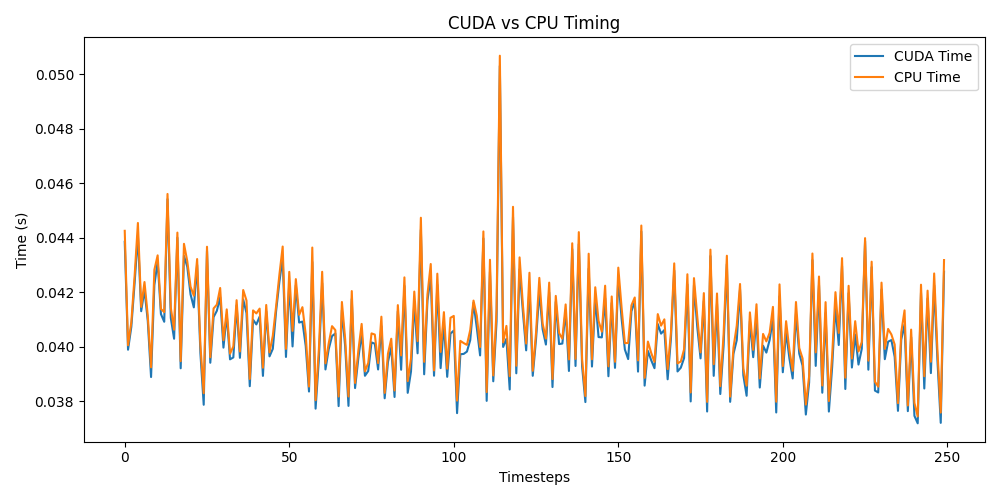

In [22]:
fig, axis = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)

axis[0,0].plot(timings_cuda, label='CUDA Time')
axis[0,0].plot(timings_cpu, label='CPU Time')
axis[0,0].set_xlabel('Timesteps')
axis[0,0].set_ylabel('Time (s)')
axis[0,0].set_title('CUDA vs CPU Timing')
axis[0,0].legend()

fig.tight_layout()

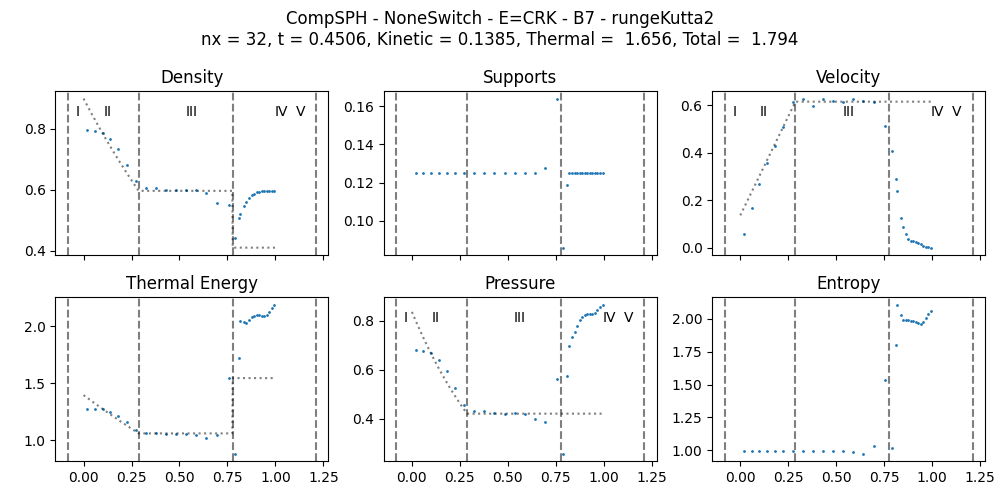

In [8]:
plotSod(states[-1], solverConfig, states[0].domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [69]:
referenceState = copy.deepcopy(states[-1])

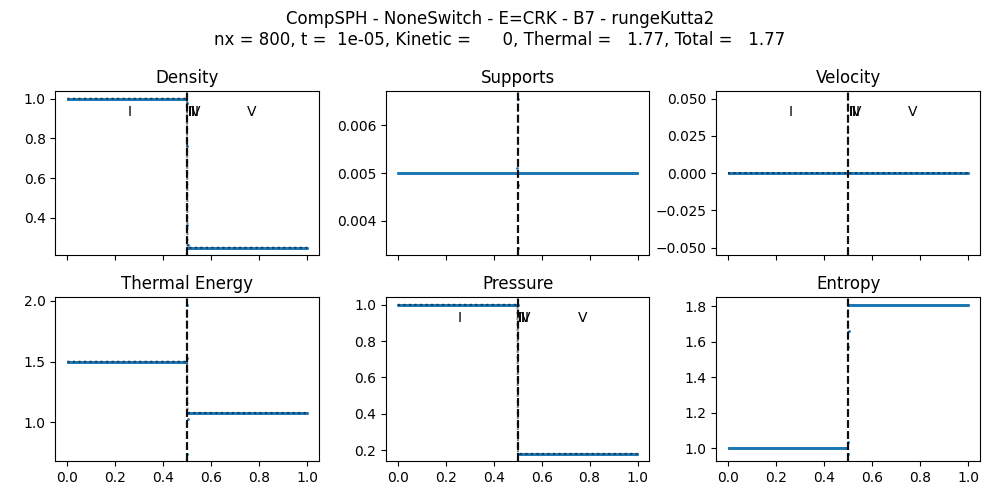

In [70]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None

masses = simulationState.systemState.masses.detach().clone() + torch.randn_like(simulationState.systemState.masses) * 0.01 * simulationState.systemState.masses.max()

masses.requires_grad = True
simulationState.systemState.masses = masses

with torch.no_grad():
    plotSod(simulationState, solverConfig, simulationState.domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [71]:


# for i in (tq:=tqdm(range(timesteps))):
#     simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
#     simulationState.priorStep = [updates[-1], currentState[-1]]
    
#     with torch.no_grad():
#         states.append(simulationState.nograd().to(device='cpu'))

#     kineticEnergy = 0.5 * (torch.linalg.norm(simulationState.systemState.velocities, dim = -1) **2 * simulationState.systemState.masses).sum()
#     thermalEnergy = (simulationState.systemState.internalEnergies * simulationState.systemState.masses).sum()
#     totalEnergy = kineticEnergy + thermalEnergy

#     tq.set_postfix({
#         'Kinetic Energy': kineticEnergy.item(),
#         'Thermal Energy': thermalEnergy.item(),
#         'Total Energy': totalEnergy.item(),
#         'Time': simulationState.t.item()
#     })


In [72]:

# with torch.no_grad():
#     plotSod(simulationState, solverConfig, simulationState.domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

In [73]:
# rhoLoss = torch.mean((simulationState.systemState.densities - referenceState.systemState.densities)**2)
# rhoLoss.backward()

In [74]:
fourierModes = 32
weights = torch.rand(fourierModes, device=device, dtype=dtype)
noise = torch.zeros_like(simulationState.systemState.masses)
for i in range(fourierModes):
    noise += weights[i] * torch.sin(2 * torch.pi * i * simulationState.systemState.positions[:,0]) / 10

print(noise.min(), noise.max())

tensor(-1.1629, device='cuda:0') tensor(1.1629, device='cuda:0')


In [88]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None

masses = simulationState.systemState.masses.detach().clone() + torch.randn_like(simulationState.systemState.masses) * 0.1 * simulationState.systemState.masses

# masses = simulationState.systemState.masses.detach().clone() + noise * simulationState.systemState.masses * 0.01


initialMasses = masses.clone()


massIterations = []

masses.requires_grad = True
simulationState.systemState.masses = masses

optimizer = torch.optim.AdamW([masses], lr = 1e-3)

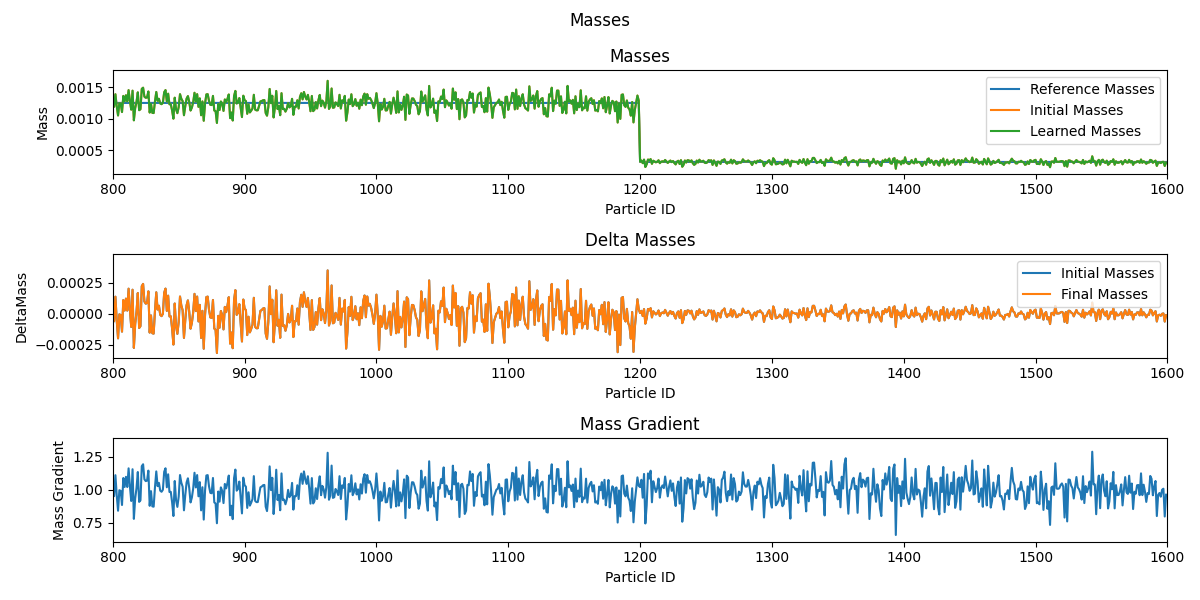

In [89]:
fig, axis = plt.subplots(3, 1, figsize=(12, 6), squeeze=False)
fig.suptitle('Masses')
axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses')
axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
axis[0,0].plot(simulationState.systemState.masses.detach().cpu().numpy(), label = 'Learned Masses')
axis[0,0].set_title('Masses')
axis[0,0].set_xlabel('Particle ID')
axis[0,0].set_ylabel('Mass')
axis[0,0].set_xlim(nx,2*nx)
axis[0,0].legend()

axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
axis[1,0].set_title('Delta Masses')
axis[1,0].set_xlabel('Particle ID')
axis[1,0].set_ylabel('DeltaMass')
axis[1,0].set_xlim(nx,2*nx)
axis[1,0].legend()

axis[2,0].plot(masses.detach().cpu().numpy() / referenceState.systemState.masses.detach().cpu().numpy(), label = 'Mass Gradient')
axis[2,0].set_title('Mass Gradient')
axis[2,0].set_xlabel('Particle ID')
axis[2,0].set_ylabel('Mass Gradient')
axis[2,0].set_xlim(nx,2*nx)
# axis[2,0].legend()

fig.tight_layout()

In [90]:
from sphMath.neighborhood import PointCloud, DomainDescription, buildNeighborhood, filterNeighborhood, coo_to_csrsc, coo_to_csr, filterNeighborhoodByKind
from sphMath.neighborhood import SupportScheme, evaluateNeighborhood
from sphMath.modules.density import computeDensity

In [96]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
states = []
priorStep = None

# masses = simulationState.systemState.masses.detach().clone() + noise * simulationState.systemState.masses.mean() * 0.1
masses = simulationState.systemState.masses.detach().clone() + torch.randn_like(simulationState.systemState.masses) * 0.1 * simulationState.systemState.masses

initialMasses = masses.clone()


massIterations = []

masses.requires_grad = True
simulationState.systemState.masses = masses

optimizer = torch.optim.AdamW([masses], lr = 1e-4)

for i in (tq:=tqdm(range(250))):
    optimizer.zero_grad()
    simulationState = copy.deepcopy(particleSystem)
    simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
    simulationState.systemState.masses = masses

    neighborhood, neighbors = evaluateNeighborhood(simulationState.systemState, solverConfig['domain'], kernel, verletScale = 1.4, mode = SupportScheme.SuperSymmetric, priorNeighborhood=None, computeDkDh = True, computeHessian = False, useCheckpoint=False)
    simulationState.neighborhoodInfo = neighborhood
    simulationState.systemState.densities = computeDensity(simulationState.systemState, kernel, neighbors.get('noghost'), SupportScheme.Gather, solverConfig)


    priorStep = None

    for ii in (t:=tqdm(range(timesteps), leave=False)):
        simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
        simulationState.priorStep = [updates[-1], currentState[-1]]
        
    # rhoLoss.backward()

    rhoLoss = torch.mean((simulationState.systemState.densities - referenceState.systemState.densities)**2)
    thermalEnergyLoss = torch.mean((simulationState.systemState.internalEnergies - referenceState.systemState.internalEnergies)**2)
    positionLoss = torch.mean((simulationState.systemState.positions - referenceState.systemState.positions)**2)
    
    loss = rhoLoss + thermalEnergyLoss + positionLoss
    # loss = thermalEnergyLoss
    loss.backward()

    # maxGradient = torch.max(torch.abs(masses.grad))
    # if maxGradient > 0.01 * simulationState.systemState.masses.max():
        # print(f'Clamping gradients: {maxGradient.item()}')
        # Clamp gradients to prevent large updates
        # masses.grad = masses.grad / maxGradient * 0.1 * referenceState.systemState.masses.mean()
        # Clamp the gradients to a reasonable range
        # print(f'Clamped gradients: {torch.max(torch.abs(masses.grad)).item()}')
    # torch.nn.utils.clip_grad_value_([masses], 10.0 * simulationState.systemState.masses.mean())
    # masses.grad.clamp_(-0.01 * simulationState.systemState.masses.max(), 0.01 * simulationState.systemState.masses.max())

    optimizer.step()
    # masses.clamp_(0.01 * referenceState.systemState.masses.min(), 10 * referenceState.systemState.masses.max())

    # if i % 25 == 0:
        # optimizer.param_groups[0]['lr'] *= 0.5

    tq.set_postfix({
        'Rho Loss': rhoLoss.item(),
        'Thermal Energy Loss': thermalEnergyLoss.item(),
        'Position Loss': positionLoss.item(),
        'Masses': (masses.detach().cpu().numpy().min(), masses.detach().cpu().numpy().max(), masses.detach().cpu().numpy().mean()),
    })

    axis[0,0].cla()
    axis[1,0].cla()
    axis[2,0].cla()
    axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses', c = 'black')
    axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
    axis[0,0].plot(masses.detach().cpu().numpy(), label = 'Learned Masses')
    axis[0,0].set_title('Masses')
    axis[0,0].set_xlabel('Particle ID')
    axis[0,0].set_ylabel('Mass')
    axis[0,0].set_xlim(nx,2*nx)
    axis[0,0].legend()

    axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
    axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
    axis[1,0].set_title('Delta Masses')
    axis[1,0].set_xlabel('Particle ID')
    axis[1,0].set_ylabel('DeltaMass')
    axis[1,0].set_xlim(nx,2*nx)
    # axis[1,0].legend()
        
    axis[2,0].plot(masses.grad.detach().cpu().numpy(), label = 'Mass Gradient')
    axis[2,0].set_title('Mass Gradient')
    axis[2,0].set_xlabel('Particle ID')
    axis[2,0].set_ylabel('Mass Gradient')
    axis[2,0].set_xlim(nx,2*nx)

    fig.suptitle(f'Masses - Iteration {i+1} - Loss: {loss.item():.2e} - Rho Loss: {rhoLoss.item():.2e} - Thermal Energy Loss: {thermalEnergyLoss.item():.2e} - Position Loss: {positionLoss.item():.2e}')

    fig.canvas.draw()
    fig.canvas.flush_events()
    # massIterations.append(masses.detach().cpu().numpy().copy())
    

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

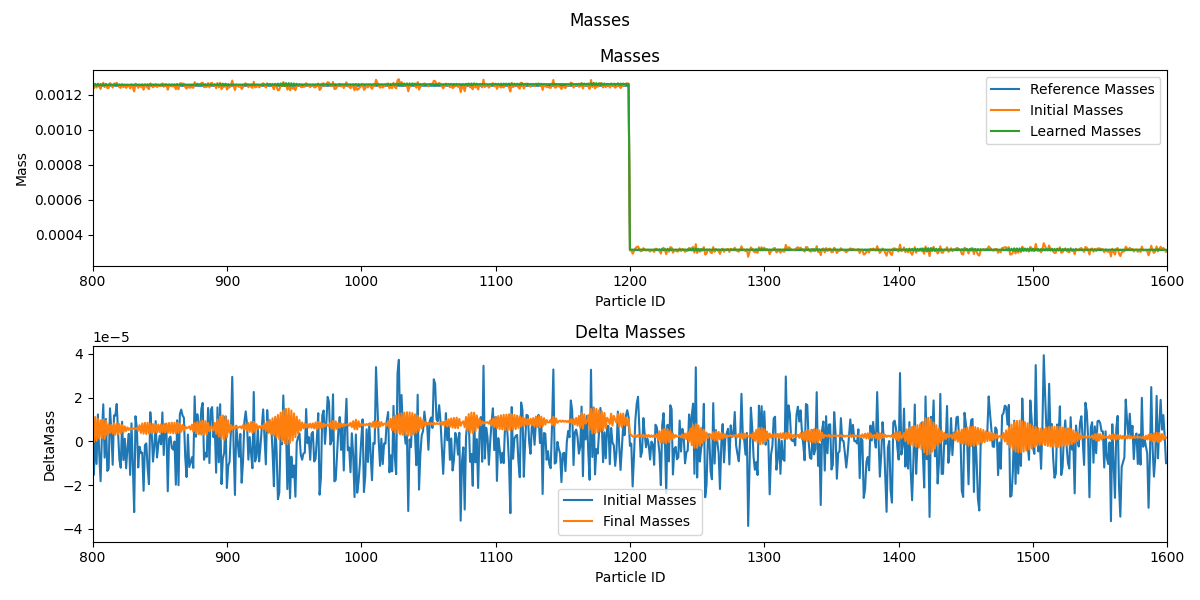

In [63]:
fig, axis = plt.subplots(2, 1, figsize=(12, 6), squeeze=False)
fig.suptitle('Masses')
axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses')
axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
axis[0,0].plot(simulationState.systemState.masses.detach().cpu().numpy(), label = 'Learned Masses')
axis[0,0].set_title('Masses')
axis[0,0].set_xlabel('Particle ID')
axis[0,0].set_ylabel('Mass')
axis[0,0].set_xlim(nx,2*nx)
axis[0,0].legend()

axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
axis[1,0].set_title('Delta Masses')
axis[1,0].set_xlabel('Particle ID')
axis[1,0].set_ylabel('DeltaMass')
axis[1,0].set_xlim(nx,2*nx)
axis[1,0].legend()

fig.tight_layout()

In [66]:
simulationState = copy.deepcopy(particleSystem)
simulationState.systemState.divergence = torch.zeros_like(simulationState.systemState.densities)
simulationState.systemState.masses = masses

for i in (t:=tqdm(range(862), leave=False)):
    simulationState, currentState, updates = integrator.function(simulationState, dt, simulator, solverConfig, priorStep = priorStep)
    simulationState.priorStep = [updates[-1], currentState[-1]]
    

  0%|          | 0/862 [00:00<?, ?it/s]

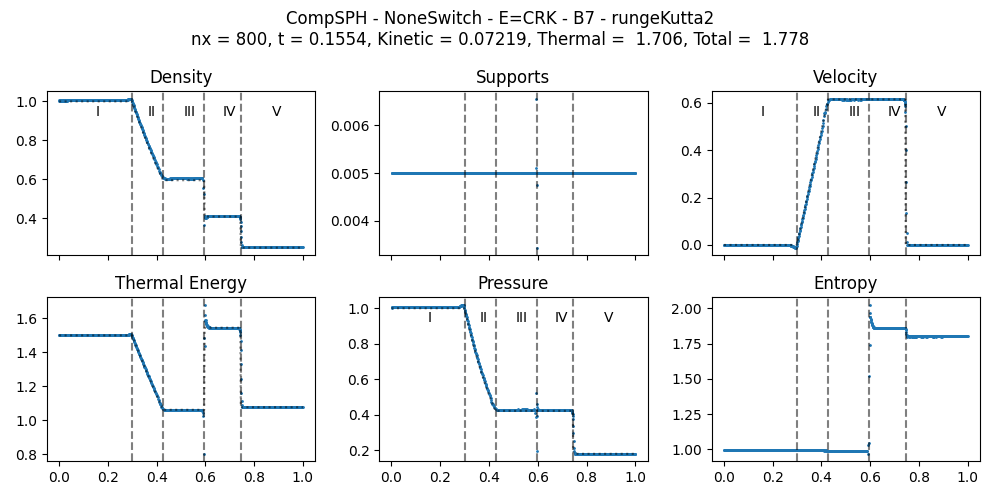

: 

In [ ]:
with torch.no_grad():
    plotSod(simulationState, solverConfig, simulationState.domain, gamma, initialStateLeft, initialStateRight, plotReference = True, plotLabels = True, scatter = True)

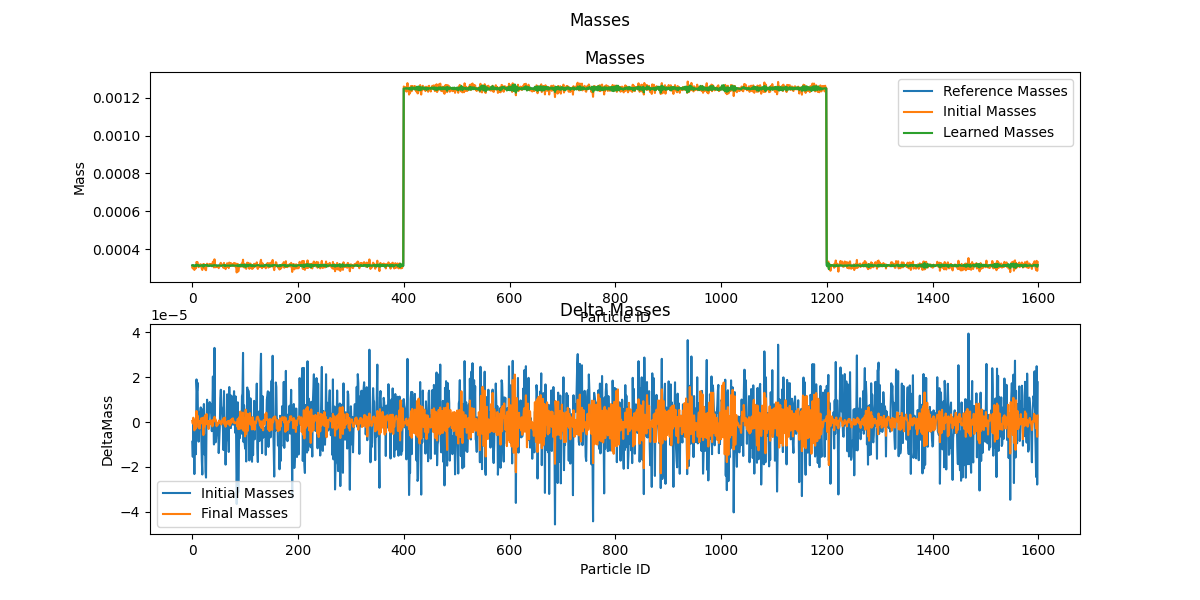

In [38]:
fig, axis = plt.subplots(2, 1, figsize=(12, 6), squeeze=False)
fig.suptitle('Masses')
axis[0,0].plot(referenceState.systemState.masses.detach().cpu().numpy(), label = 'Reference Masses')
axis[0,0].plot(initialMasses.detach().cpu().numpy(), label = 'Initial Masses')
axis[0,0].plot(simulationState.systemState.masses.detach().cpu().numpy(), label = 'Learned Masses')
axis[0,0].set_title('Masses')
axis[0,0].set_xlabel('Particle ID')
axis[0,0].set_ylabel('Mass')
axis[0,0].legend()

axis[1,0].plot(initialMasses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Initial Masses')
axis[1,0].plot(masses.detach().cpu().numpy() - referenceState.systemState.masses.detach().cpu().numpy(), label = 'Final Masses')
axis[1,0].set_title('Delta Masses')
axis[1,0].set_xlabel('Particle ID')
axis[1,0].set_ylabel('DeltaMass')
axis[1,0].legend()
